In [1]:
%matplotlib inline
from kid_readout.measurement.io import npy
from kid_readout.measurement import temperature
from kid_readout.analysis.resonator.plot_resonator import amplitude
from kid_readout.analysis.timeseries import binning, iqnoise

In [2]:
npd150 = npy.NumpyDirectory('/data/detectors/2016-10-27_201756_sweep_stream_simultaneous/')
npd350 = npy.NumpyDirectory('/data/detectors/2016-10-27_223343_sweep_stream_simultaneous/')

In [3]:
num_attenuations = 5

In [4]:
all150 = [npd150.read(name) for name in npd150.node_names() if name.startswith('SweepStreamArray')]
low150 = all150[:num_attenuations]
high150 = all150[num_attenuations:]

all350 = [npd350.read(name) for name in npd350.node_names() if name.startswith('SweepStreamArray')]
low350 = all350[:num_attenuations]
high350 = all350[num_attenuations:]

In [18]:
def analyze(sss):
    sss.set_S(window=plt.mlab.window_hanning, noverlap=None, bins_per_decade=10)

In [19]:
low_numbers = range(3)  # low[3] is a dummy channel
high_numbers = range(4)

In [20]:
cold_attenuation_index = 2
warm_attenuation_index = 0
for sss in ([low150[cold_attenuation_index][number] for number in low_numbers] +
            [high150[cold_attenuation_index][number] for number in high_numbers] +
            [low350[warm_attenuation_index][number] for number in low_numbers] +
            [high350[warm_attenuation_index][number] for number in high_numbers]):
    analyze(sss)

In [48]:
def coherence(sss_a, sss_b):
    return np.abs(sss.S_xy)**2 / (sss.S_xx * sss.S_yy)

def plot_coherence_matrix(sss_list, figsize=None, xlimits=(1e-1, 2e4),
                          S_ylimits=(1e-20, 1e-15), mag_ylimits=(1e-3, 1.5), phase_ylimits=(-200, 200),
                          x_color='darkred', y_color='darkgreen', alpha=0.6):
    if figsize is None:
        figsize = (len(sss_list), len(sss_list))
    fig, axes = plt.subplots(len(sss_list), len(sss_list), figsize=figsize)
    twin_axes = np.array([ax.twinx() for ax in axes.flatten()]).reshape(len(sss_list), len(sss_list))
    for first in range(len(sss_list)):
        for second in range(first, len(sss_list)):
            if first == second:
                C_ax = axes[first, second]
                S_ax = twin_axes[first, second]
                sss = sss_list[first]
                C_ax.loglog(sss.S_frequency, np.abs(sss.S_xy)**2 / (sss.S_xx * sss.S_yy),
                            color='blue', alpha=0.5)
                S_ax.loglog(sss_list[first].S_frequency, sss_list[first].S_xx, color=x_color,
                          label='$S_{xx}$', alpha=alpha)
                S_ax.loglog(sss_list[first].S_frequency, sss_list[first].S_yy, color=y_color,
                          label='$S_{yy}$', alpha=alpha)
                C_ax.set_xlim(*xlimits)
                C_ax.set_ylim(*mag_ylimits)
                S_ax.set_ylim(*S_ylimits)
                
                if first == second == 0:
                    C_ax.set_xticklabels([])
                    S_ax.set_yticklabels([])
                elif first == second == len(sss_list) - 1:
                    C_ax.set_yticklabels([])
                else:
                    C_ax.set_xticklabels([])
                    C_ax.set_yticklabels([])
                    S_ax.set_yticklabels([])
            else:  # Plot the magnitude and phase of the coherence for both xx (lower left) and yy (upper right)
                xx_mag_ax = axes[second, first]
                xx_phase_ax = twin_axes[second, first]
                yy_mag_ax = axes[first, second]
                yy_phase_ax = twin_axes[first, second]

                sss1 = sss_list[first]
                sss2 = sss_list[second]
                xx_aac = iqnoise.auto_auto_cross(a=sss1.x, b=sss2.x, sample_rate=sss1.stream.stream_sample_rate)
                yy_aac = iqnoise.auto_auto_cross(a=sss1.y, b=sss2.y, sample_rate=sss1.stream.stream_sample_rate)

                xx_phase_ax.semilogx(xx_aac.f, np.degrees(np.angle(xx_aac.S_ab)),
                                     linestyle='none', marker='>', markersize=1.5,
                                     color='red', alpha=alpha)
                xx_mag_ax.loglog(xx_aac.f,
                          np.abs(xx_aac.S_ab)**2 / (xx_aac.S_aa * xx_aac.S_bb),
                          '-', color=x_color, alpha=alpha)
                xx_mag_ax.set_xlim(*xlimits)
                xx_mag_ax.set_ylim(*mag_ylimits)
                xx_phase_ax.set_ylim(*phase_ylimits)

                yy_phase_ax.semilogx(yy_aac.f, np.degrees(np.angle(yy_aac.S_ab)),
                                     linestyle='none', marker='>', markersize=1.5,
                                     color='green', alpha=alpha)
                yy_mag_ax.loglog(yy_aac.f,
                          np.abs(yy_aac.S_ab)**2 / (yy_aac.S_aa * yy_aac.S_bb),
                          '-', color=y_color, alpha=alpha)
                yy_mag_ax.set_xlim(*xlimits)
                yy_mag_ax.set_ylim(*mag_ylimits)
                yy_phase_ax.set_ylim(*phase_ylimits)

                phase_yticks = [-180, -90, 0, 90, 180]
                xx_phase_ax.set_yticks(phase_yticks)
                yy_phase_ax.set_yticks(phase_yticks)
                if second == len(sss_list) - 1 and first == 0:
                    xx_phase_ax.set_yticklabels([])
                    yy_mag_ax.set_yticklabels([])
                    yy_mag_ax.set_xticklabels([])
                else:
                    xx_mag_ax.set_xticklabels([])
                    xx_mag_ax.set_yticklabels([])
                    xx_phase_ax.set_yticklabels([])
                    yy_mag_ax.set_xticklabels([])
                    yy_mag_ax.set_yticklabels([])
                    yy_phase_ax.set_yticklabels([])
                   
    return fig, axes

In [22]:
plt.rcParams['xtick.labelsize'] = 4
plt.rcParams['ytick.labelsize'] = 4

# 150 mK

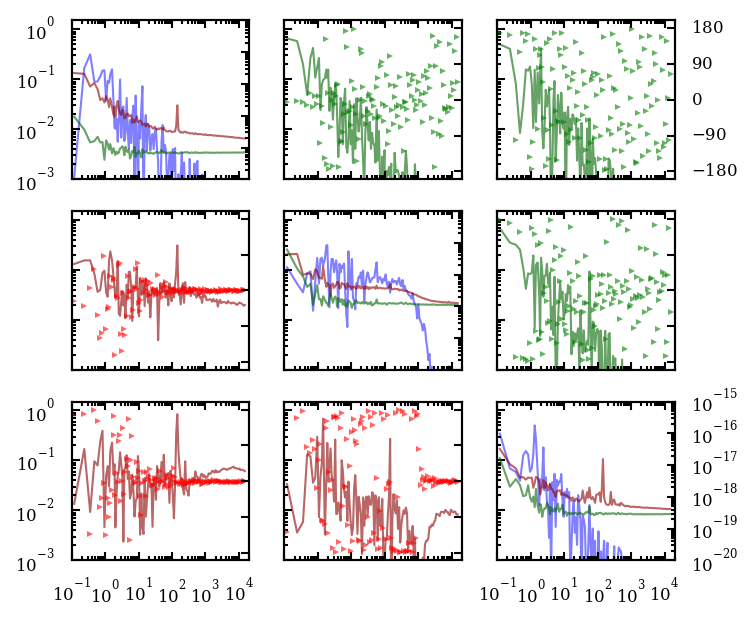

In [49]:
fig, axes = plot_coherence_matrix([low150[cold_attenuation_index][number] for number in low_numbers])

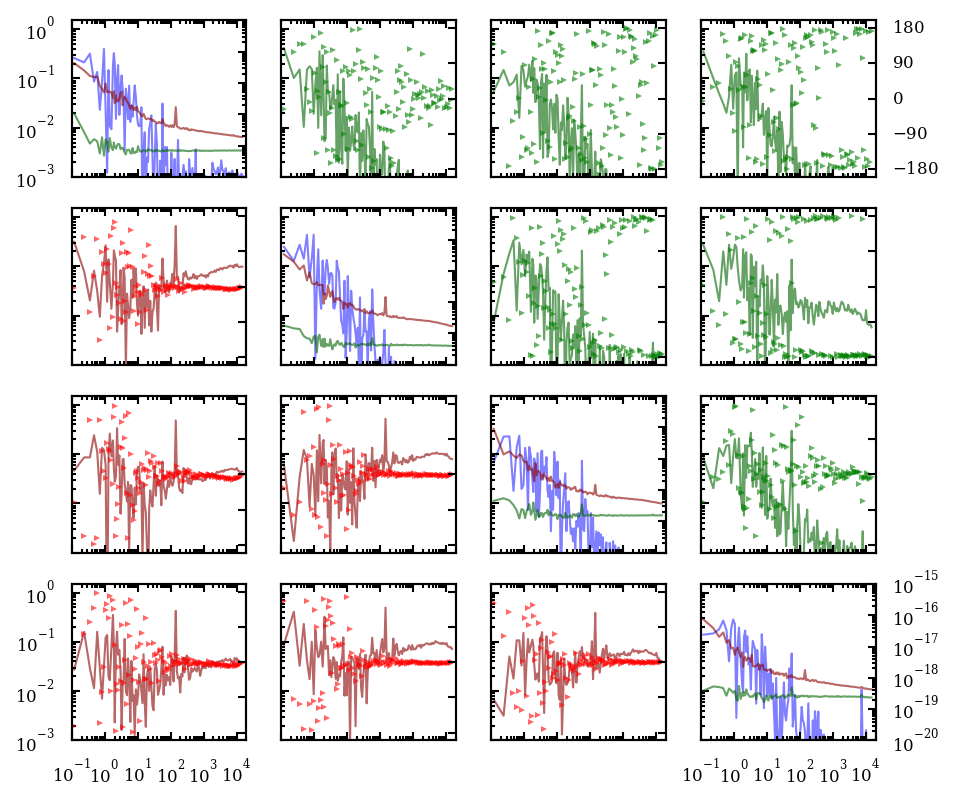

In [50]:
fig, axes = plot_coherence_matrix([high150[cold_attenuation_index][number] for number in high_numbers])

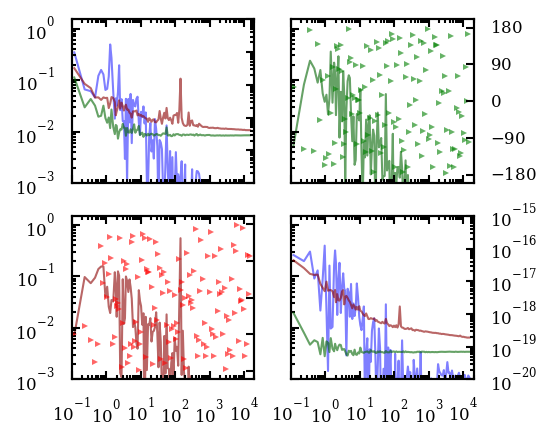

In [51]:
fig, axes = plot_coherence_matrix([low150[cold_attenuation_index][2], high150[cold_attenuation_index][0]])

# 380 mK

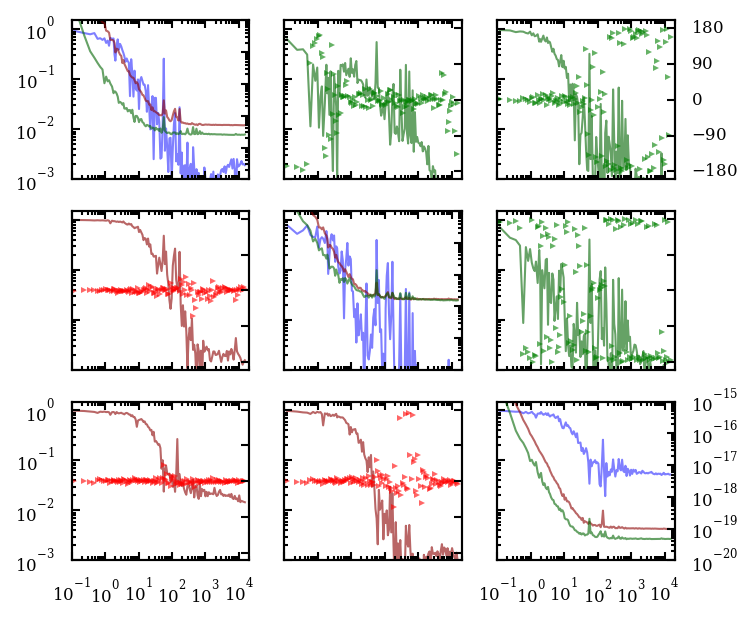

In [52]:
fig, axes = plot_coherence_matrix([low350[warm_attenuation_index][number] for number in low_numbers])

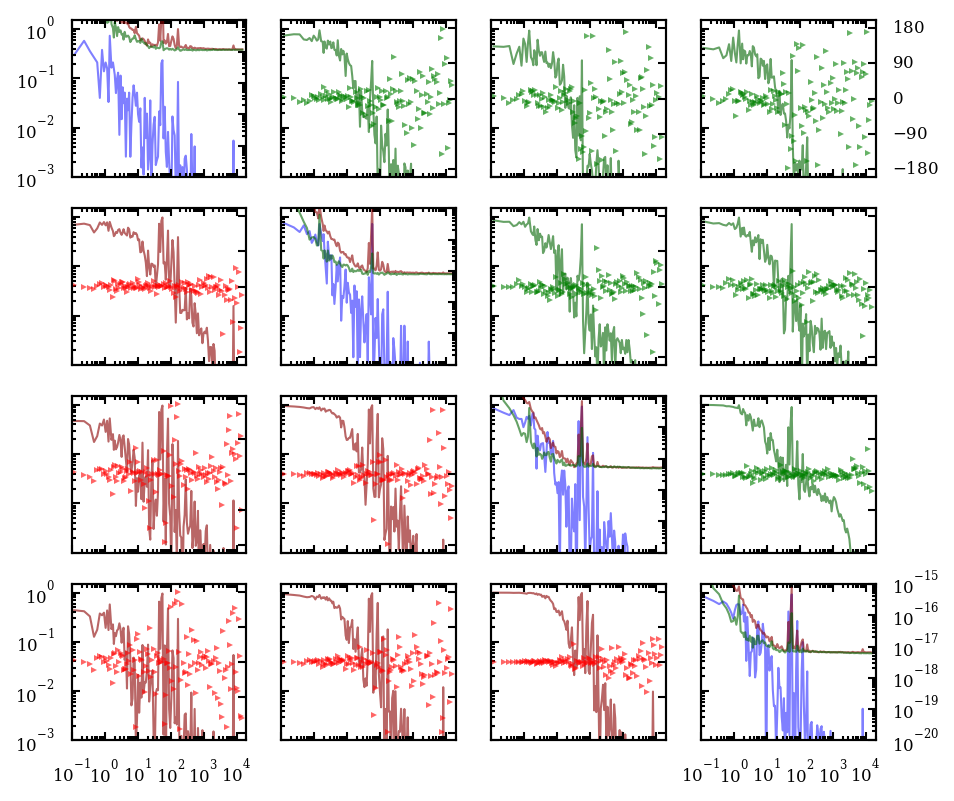

In [53]:
fig, axes = plot_coherence_matrix([high350[warm_attenuation_index][number] for number in high_numbers])

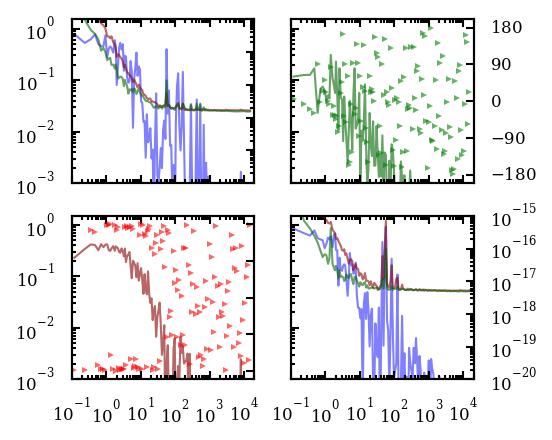

In [57]:
fig, axes = plot_coherence_matrix([low350[warm_attenuation_index][1], high350[warm_attenuation_index][2]])

# One

In [29]:
attenuation_index = 3
resonator_index = 1
cold = analyze(low150[attenuation_index][resonator_index])
hot = analyze(low350[attenuation_index][resonator_index])

In [30]:
cold.resonator.f_0

AttributeError: 'NoneType' object has no attribute 'resonator'

In [ ]:
cold.stream.roach_state.dac_attenuation

In [ ]:
hot.resonator.f_0

In [ ]:
hot.stream.roach_state.dac_attenuation

In [ ]:
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')
ax.plot(cold.S_frequency, cold.S_xx, '-b', linewidth=0.4, label='$S_{xx}$ 150 mK')
ax.plot(cold.S_frequency, cold.S_yy, '-b', linewidth=0.2, label='$S_{yy}$ 150 mK')
ax.plot(hot.S_frequency, hot.S_xx, '-r', linewidth=0.4, label='$S_{xx}$ 350 mK')
ax.plot(hot.S_frequency, hot.S_yy, '-r', linewidth=0.2, label='$S_{yy}$ 350 mK')
ax.set_xlim(1e-1, 2e4)
ax.legend(loc='best', fontsize='xx-small');

In [ ]:
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')
ax.plot(cold.S_frequency, cold.coherence, '-b', label='$C_{xy}$ 150 mK', alpha=0.5)
ax.plot(hot.S_frequency, hot.coherence, '-r', label='$C_{xy}$ 350 mK', alpha=0.5)
ax.set_xlim(1e-1, 2e4)
ax.set_ylim(1e-3, 1.5)
ax.legend(loc='best', fontsize='xx-small');

In [ ]:
a = high150[2][0]
b = low150[2][2]
aac = iqnoise.auto_auto_cross(X=a.x, Y=b.x, sample_rate=a.stream.stream_sample_rate)
coh = np.abs(aac.S_XY)**2 / (aac.S_XX * aac.S_YY)

In [ ]:
fig, ax = plt.subplots()
c_ax = ax.twinx()
ax.set_xscale('log')
ax.set_yscale('log')
c_ax.set_yscale('log')
ax.plot(aac.f, aac.S_XX, '-r', label='aa', alpha=0.5)
ax.plot(aac.f, aac.S_YY, '-b', label='bb', alpha=0.5)
c_ax.plot(aac.f, coh, color='purple', label='ab', alpha=0.5)
c_ax.set_ylim(1e-3, 1)